#**🚨 Before Running the Script Please Make Sure you have selected the Run Time as GPU**

#**Step 01: Installing the Packages**

In [1]:
%%capture
!pip install super-gradients==3.1.0
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

#**🚨 Restart the Run Time**

#**Step 02: Importing all the required libraries**

In [1]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

[2023-06-22 11:47:49] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-06-22 11:47:56] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-06-22 11:47:56] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-06-22 11:47:56] WARNING - export.py - Failed to import pytorch_quantization
[2023-06-22 11:47:56] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [2]:
from IPython.display import clear_output


In [3]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback



In [4]:
from super_gradients.training import models


#**Step 03: Setting the checkpoint directory and experiment name | Instantiated the trainer**

In [5]:
CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='drone_yolonas_run', ckpt_root_dir=CHECKPOINT_DIR)

#**Step 04: Exporting the Dataset from Roboflow into the Google Colab Notebook**

In [6]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="oaSwA6w5F7VRpQb28Mqs")
project = rf.workspace("drone-dataset-mvh8i").project("detection-bzujh")
dataset = project.version(1).download("yolov5")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to detection-1 in yolov5pytorch::  88%|████████▊ | 8249/9374 [00:01<00:00, 7677.10it/s]

#**Step 05: Load your dataset parameters into a dictionary**

You'll need to load your dataset parameters into a dictionary, specifically defining:

- path to the parent directory where your data lives
- the child directory names for training, validation, and test (if you have testing set) images and labels
- class names

In [7]:
dataset_params = {
    'data_dir':'/content/detection-1',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['boat', 'camping car', 'car', 'motorcycle', 'other', 'pickup', 'plane', 'tractor', 'truck', 'van']
}



#**Step 06: Pass the values for `dataset_params` into the `dataset_params` argument as shown below.**

In [8]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

#**Step 07: Inspect the Dataset Defined Earlier**

In [9]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': [640, 640], 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': [640, 640], 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5, 'max_targets': 120),
 DetectionPaddedRescale('swap': (2, 0, 1),

In [10]:
train_data.dataset.dataset_params['transforms'][1]

{'DetectionRandomAffine': {'degrees': 10.0, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

In [11]:
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42

#**Step 08: Plot a batch of training data with their augmentations applied to see what they look like**

Caching annotations: 100%|██████████| 11/11 [00:00<00:00, 2582.99it/s]


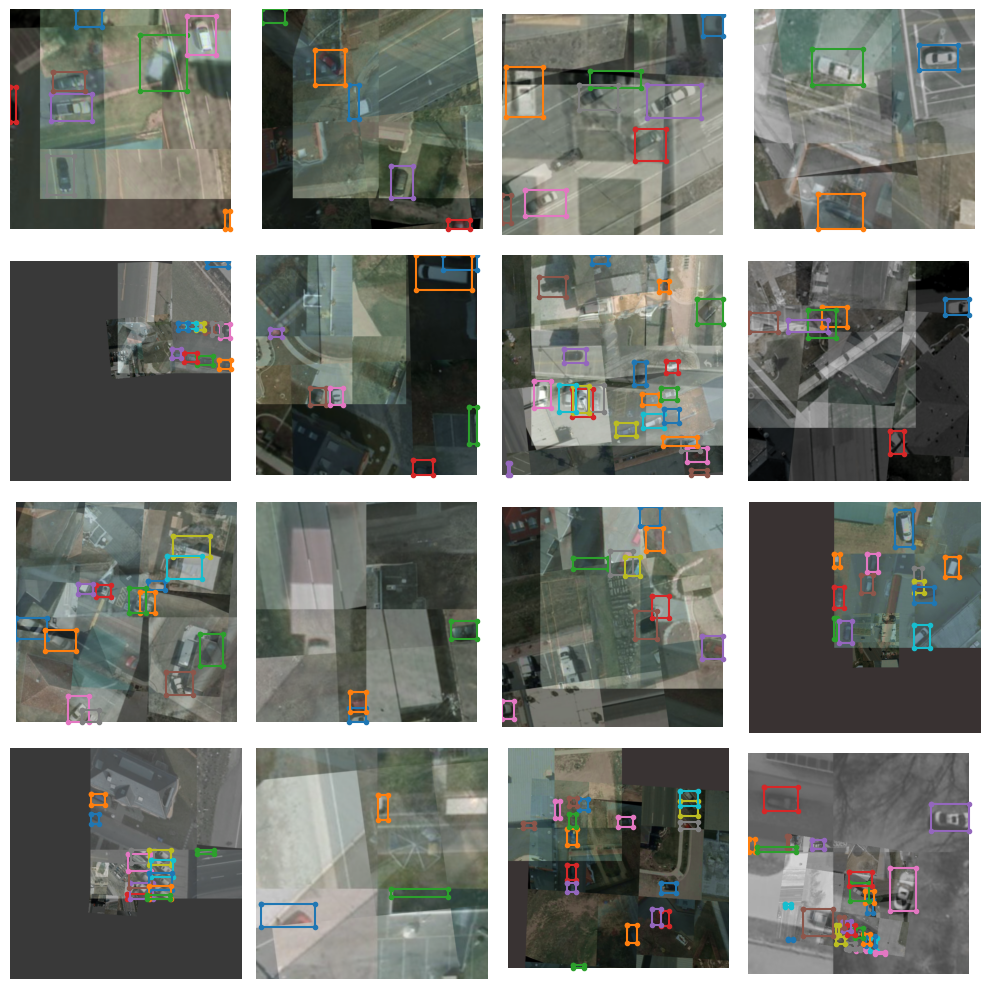

In [12]:
train_data.dataset.plot()

#**Step 09: Instantiating the model**


You saw how to instantiate the model for inference earlier.

Below is how to instantiate the model for finetuning. Note you need to add the `num_classes` argument here.

Note, for this tutorial we are using `yolo_nas_s`, but SuperGradients has two other flavors of YOLONAS available to you: `yolo_nas_m` and `yolo_nas_l`.

In [13]:
model = models.get('yolo_nas_s',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

[2023-06-22 11:48:18] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth


  0%|          | 0.00/73.1M [00:00<?, ?B/s]

#**Step 10: 📊 Define metrics and training parameters**


We need to define the training parameters for your training run.

Full details about the training parameters can be found [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/training_hyperparams/default_train_params.yaml).


### 🚨 There are a few **mandatory** arguments that we must define for training params 🚨

- `max_epochs` - Max number of training epochs

- `loss` - the loss function you want to use

- `optimizer` - Optimizer you will be using

- `train_metrics_list` - Metrics to log during training

- `valid_metrics_list` - Metrics to log during training

- `metric_to_watch` - metric which the model checkpoint will be saved according to

We can choose from a variety of `optimizer`'s such as: Adam, AdamW, SGD, Lion, or RMSProps. If you choose to change the defualt parameters of these optimizrs you pass them into `optimizer_params`.


In [14]:
train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
     ],
    "metric_to_watch": 'mAP@0.50'
}

#**Step 11: Download the Demo Videos**

In [15]:
!gdown "https://drive.google.com/uc?id=1UUZUS76ylH5RjMSc9s4rITSYDTG5AHt0&confirm=t"


Downloading...
From: https://drive.google.com/uc?id=1UUZUS76ylH5RjMSc9s4rITSYDTG5AHt0&confirm=t
To: /content/test4.mp4
  0% 0.00/7.96M [00:00<?, ?B/s]

In [16]:
!gdown "https://drive.google.com/uc?id=1MaH6dNoegFjwkhtedxXufn2UD7EPpF_w&confirm=t"


#**Step 12: 🦾 Training the model**

You've covered a lot of ground so far:

✅ Instantiated the trainer

✅ Defined your dataset parameters and dataloaders

✅ Instantiated a model

✅ Set up your training parameters

### ⏳ Now, its time to train a model

Training a model using a SuperGradients is done using the `trainer`.

It's as easy as...

In [17]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

100% 7.96M/7.96M [00:00<00:00, 29.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MaH6dNoegFjwkhtedxXufn2UD7EPpF_w&confirm=t
To: /content/test2.mp4
100% 3.79M/3.79M [00:00<00:00, 156MB/s]


[2023-06-22 11:48:26] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-06-22 11:48:31] INFO - utils.py - NumExpr defaulting to 2 threads.


The console stream is now moved to checkpoints/drone_yolonas_run/console_Jun22_11_48_31.txt


[2023-06-22 11:48:38] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 4050       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         253        (len(train_loader))
    - Gradient updates per epoch:   253        (len(train_loader) / batch_accumulate)

[2023-06-22 11:53:01] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/drone_yolonas_run/ckpt_best.pth
[2023-06-22 11:53:01] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.0027046853210777044
[2023-06-22 11:57:18] INFO - base_sg_logger.py - Checkpoint saved in che

#**Step 13: 🏆 Get the best trained model**

In [19]:
best_model = models.get('yolo_nas_s',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/content/checkpoints/drone_yolonas_run/ckpt_best.pth")

[2023-06-22 13:03:53] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/checkpoints/drone_yolonas_run/ckpt_best.pth EMA checkpoint.


#**Step 14: 🔮 Predicting with the best model**



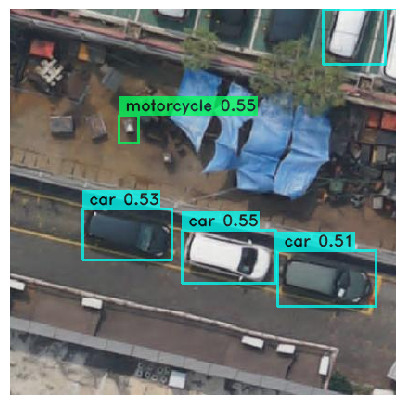

In [20]:
img_url = '/content/detection-1/test/images/30017_jpg.rf.50b4cf0957b5247caa119a1e6e65cd4e.jpg'
best_model.predict(img_url).show()

#**Step 15: Testing on Video 1**

In [21]:
input_video_path = f"/content/test2.mp4"
output_video_path = "detections.mp4"

In [22]:
import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [23]:
best_model.to(device).predict(input_video_path).save(output_video_path)

Predicting Video: 100%|██████████| 319/319 [00:09<00:00, 34.38it/s]


#**Display the Output Video**

In [25]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = '/content/detections.mp4'

# Compressed video path
compressed_path = "/content/result_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

#**Step 16: Testing on Video 2**

In [26]:
input_video_path = f"/content/test4.mp4"
output_video_path = "detections3.mp4"

In [28]:
best_model.to(device).predict(input_video_path).save(output_video_path)

Predicting Video: 100%|██████████| 808/808 [00:28<00:00, 28.33it/s]


#**Display the Output Video**

In [29]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = '/content/detections3.mp4'

# Compressed video path
compressed_path = "/content/result_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)